# Exploració de la xarxa neuronal
- https://docs.ultralytics.com/tasks/detect/

#### Comentari: 
- Tal com comentem al document: `generador-tiquets/generador_tiquets_documentacio.ipynb` al final de tot. 
    - No sabíem si hauríem d'entrenar la xarxa neuronal amb vàries fases diferents (primer detectar secció amb els productes) i després els productes dins aquesta secció. 
- Al final ha resultat que no fa falta. 
- Però ja haviem preparat l'script de python perque generes totes les possibilitats. 
- En aquest Notebook, hi ha tots els nivells. 
- Hem generat una mostra de 5 tiquets de cada nivell.
- I, finalment, hem fet un script nou, més eficient que només genera el nivell 5 i amb foramt yolo. 

#### Per tant en aquest Notebook tenim:
- Anàlisis de tots els tiquets generats.
- Explicació per entrenar la xarxa neuronal amb aquestes dades.

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from PIL import Image, ImageDraw

In [3]:
image_root_general = "../../generador-tiquets/script_general/exports/data"

In [4]:
def coco_products_in_ticket(complexity):
    return pd.read_csv(f'{image_root_general}/complexity_{complexity}/coco/bbx_products_in_ticket.csv', dtype={'ticket_id': str})

def coco_area(complexity):
    return pd.read_csv(f'{image_root_general}/complexity_{complexity}/coco/bbx_area_products_in_ticket.csv', dtype={'ticket_id': str})

def coco_products_in_area(complexity):
    return pd.read_csv(f'{image_root_general}/complexity_{complexity}/coco/bbx_products_in_area.csv', dtype={'ticket_id': str})

#### Llistes de dataframes de totes les complexitats per cada tipus de dataset.
- Veure complexitats al repositori de generació de tiquets: `generador-tiquets/script/exports/descripció complexitats.txt`
- Tipus de dataset: 
    - df_coco_products_in_ticket = dataset amb les coordenades de cada element de cada producte en relació a tot el tiquet.
    - df_coco_area = dataset amb les coordenades de només la area on hi han els productes respecte el tiquet. 
    - df_coco_products_area = dataset amb les coordenades dels productes però només respecte el retall de la area dels productes.

In [5]:
df_coco = {
    'df_coco_products_in_ticket': [coco_products_in_ticket(i) for i in range(6)],
    'df_coco_area': [coco_area(i) for i in range(6)],
    'df_coco_products_area': [coco_products_in_area(i) for i in range(6)],
}

In [6]:
# Només productes unitaris i 5 elements:
df_coco['df_coco_products_in_ticket'][0].head()

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4
0,000001,quantitat_ud,1,"(25, 310)","(65, 310)","(25, 330)","(65, 330)"
1,000001,descripcio,NAVALLES,"(65, 310)","(265, 310)","(65, 330)","(265, 330)"
2,000001,import,"4,07","(430, 310)","(475, 310)","(430, 330)","(475, 330)"
3,000001,quantitat_ud,1,"(25, 330)","(65, 330)","(25, 350)","(65, 350)"
4,000001,descripcio,LLOM BOVÍ,"(65, 330)","(265, 330)","(65, 350)","(265, 350)"


#### Les coordenades les tenim amb string

In [7]:
df_coco['df_coco_products_in_ticket'][0].iloc[0].b_1

'(25, 310)'

In [8]:
# Les passem a tupla
import ast

cadena = '(25, 310)'
tupla = ast.literal_eval(cadena)

tupla

(25, 310)

In [9]:
def convert_str_to_tuple(df):
    df[['b_1', 'b_2', 'b_3', 'b_4']] = df.apply(lambda row: pd.Series([ast.literal_eval(row['b_1']), ast.literal_eval(row['b_2']), ast.literal_eval(row['b_3']), ast.literal_eval(row['b_4'])]), axis=1)

for key, value in df_coco.items(): 
    for df in value:
        convert_str_to_tuple(df)

In [10]:
df_coco['df_coco_products_in_ticket'][0].iloc[0].b_1

(25, 310)

#### Comprovem les coordenades
- Per `coco`: 
    - Pintem els recuadres, per veure que la informació que representa el bounding box és la correcta al tiquet.
- Per `yolo`:
    - Pintem coco y yolo, per veure que tenim el centre de coordenades al mig.
#### Coco
- Mostrem 1 mostra (1 tiquet) de cada.
- De cada tipus de dataset (els 3 possibles) i de cada nivell de complexitat (els 6 possibles) de tiquet.
- El triem de forma random.

In [11]:
def comprovar_df(df, image_root, file_name):
    print(f"=== Tiquetn amb id: {file_name}.png ===")
    df_comprobacio = df[df['ticket_id'] == file_name].reset_index()
    pilImg = Image.open('%s/%s' %(image_root, f'{file_name}.png'))
    imgdrw = ImageDraw.Draw(pilImg)
    
    # De un recuadre random del tiquet, en mostrem la informació que hi ha codificada i el pintem vermell en comptes de blau
    random_idx = random.randint(0, df_comprobacio.shape[0] - 1)
    random_element = df_comprobacio.iloc[random_idx]
    
    for i in range (0, df_comprobacio.shape[0]):
        imgdrw.rectangle([df_comprobacio.iloc[i].b_1, df_comprobacio.iloc[i].b_4], outline = 'red' if i == random_idx else 'blue', width = 2)
        plt.imshow(pilImg)
        
        if i == random_idx: 
            print(f"Etiqueta: {df_comprobacio.iloc[i].etiqueta} | Value: {df_comprobacio.iloc[i].value}")        
    plt.axis('off');
    plt.show()

#### Només per un dataset: 
```python
for i in range(6):
    # df of complexity 0,1,2,3,4,5 of products in all ticket
    df = df_coco['df_coco_products_in_ticket'][i]
        
    image_root = f'{image_root_general}/complexity_{i}/coco/tickets'
    file_name = df.ticket_id.unique()

    comprovar_df(df, image_root, random.choice(df.ticket_id.unique()))
```

#### Per tots els dataframes de cop

=== Dataset del tipus: df_coco_products_in_ticket ===
=== Complexitat del dataset: 0 ===
=== Tiquetn amb id: 000001.png ===
Etiqueta: import | Value: 2,95


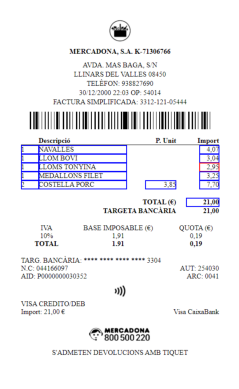

=== Complexitat del dataset: 1 ===
=== Tiquetn amb id: 000003.png ===
Etiqueta: descripcio | Value: VERDURES ROSTIDES


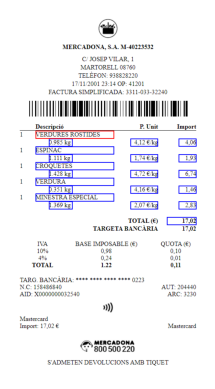

=== Complexitat del dataset: 2 ===
=== Tiquetn amb id: 000002.png ===
Etiqueta: descripcio | Value: MORTADEL·LA AMB


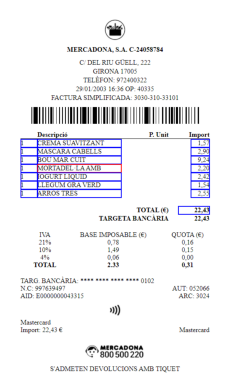

=== Complexitat del dataset: 3 ===
=== Tiquetn amb id: 000001.png ===
Etiqueta: descripcio | Value: CARXOFA


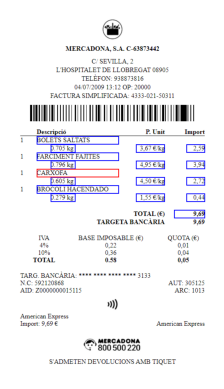

=== Complexitat del dataset: 4 ===
=== Tiquetn amb id: 000005.png ===
Etiqueta: quantitat_ud | Value: 1


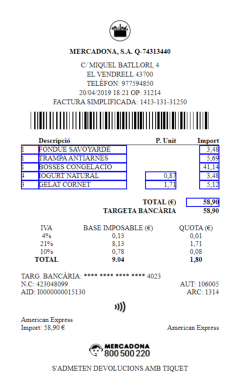

=== Complexitat del dataset: 5 ===
=== Tiquetn amb id: 000006.png ===
Etiqueta: quantitat_ud | Value: 1


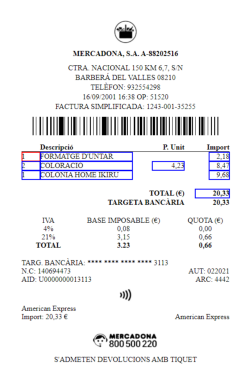

=== Dataset del tipus: df_coco_area ===
=== Complexitat del dataset: 0 ===
=== Tiquetn amb id: 000004.png ===
Etiqueta: products | Value: nan


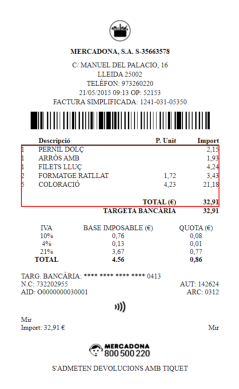

=== Complexitat del dataset: 1 ===
=== Tiquetn amb id: 000001.png ===
Etiqueta: products | Value: nan


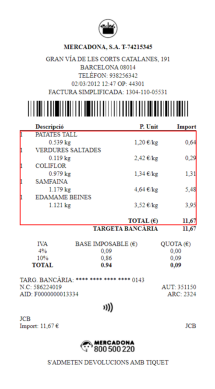

=== Complexitat del dataset: 2 ===
=== Tiquetn amb id: 000003.png ===
Etiqueta: products | Value: nan


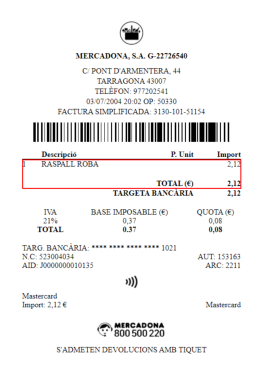

=== Complexitat del dataset: 3 ===
=== Tiquetn amb id: 000005.png ===
Etiqueta: products | Value: nan


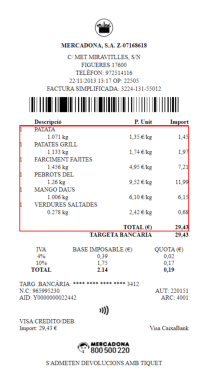

=== Complexitat del dataset: 4 ===
=== Tiquetn amb id: 000002.png ===
Etiqueta: products | Value: nan


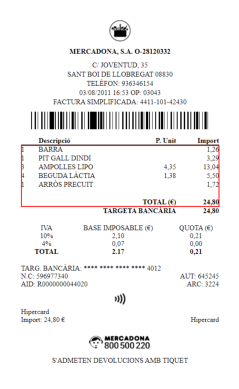

=== Complexitat del dataset: 5 ===
=== Tiquetn amb id: 000008.png ===
Etiqueta: products | Value: nan


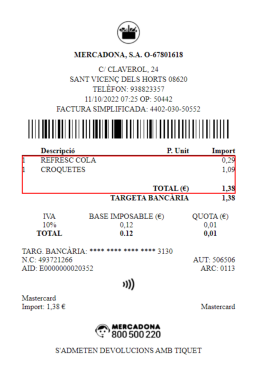

=== Dataset del tipus: df_coco_products_area ===
=== Complexitat del dataset: 0 ===
=== Tiquetn amb id: 000003.png ===
Etiqueta: quantitat_ud | Value: 1


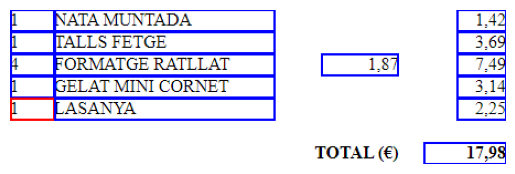

=== Complexitat del dataset: 1 ===
=== Tiquetn amb id: 000005.png ===
Etiqueta: import | Value: 3,03


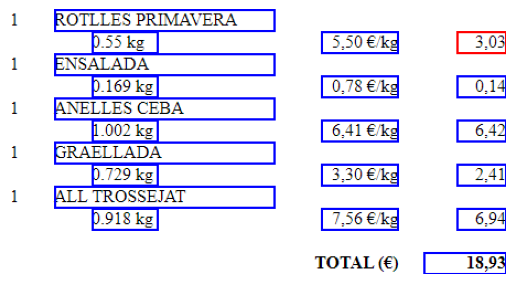

=== Complexitat del dataset: 2 ===
=== Tiquetn amb id: 000001.png ===
Etiqueta: import | Value: 1,98


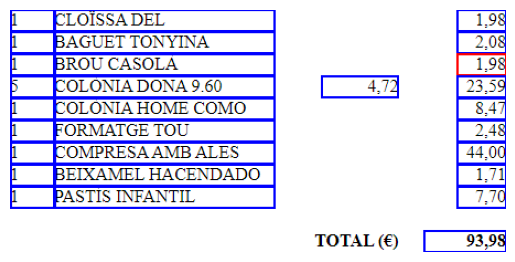

=== Complexitat del dataset: 3 ===
=== Tiquetn amb id: 000003.png ===
Etiqueta: quantitat_kg | Value: 0.922


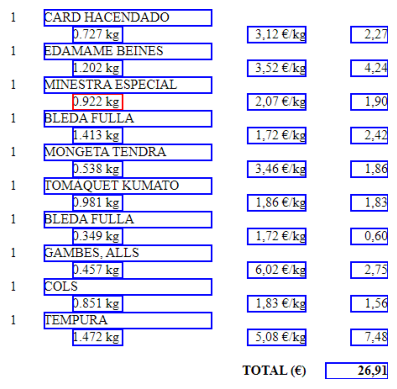

=== Complexitat del dataset: 4 ===
=== Tiquetn amb id: 000003.png ===
Etiqueta: quantitat_ud | Value: 1


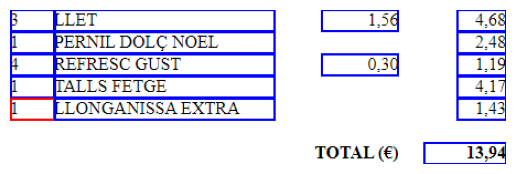

=== Complexitat del dataset: 5 ===
=== Tiquetn amb id: 000006.png ===
Etiqueta: import | Value: 9,68


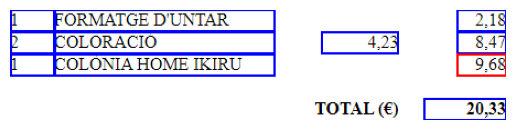

In [12]:
for key in df_coco.keys():
    print(f"=== Dataset del tipus: {key} ===")
    for i in range(6):
        print(f"=== Complexitat del dataset: {i} ===")
        df = df_coco[key][i]
        
        images_folder = 'cropped_area_products_in_ticket' if key == 'df_coco_products_area' else 'tickets'
        image_root = f'{image_root_general}/complexity_{i}/coco/{images_folder}'
        
        file_name = df.ticket_id.unique()

        comprovar_df(df, image_root, random.choice(df.ticket_id.unique()))

#### yolo
- Prova de un mostrar 1 tiquet: 

#### Per pintar necessitem les coordenades absolutes:
- Mirem la mida del tiquet i fem la enginyeria inversa.
    - `x_centre` = x_centre_norm * width de la img.
    - `y_centre` = y_centre_normm * height de la img.
- També fem enginyeria inversa per trobar els bounding boxes b_1 i b_4
    - Per assegurar que estiguin els números bé. 
    - https://medium.com/red-buffer/converting-a-custom-dataset-from-coco-format-to-yolo-format-6d98a4fd43fc

In [13]:
image_root = f'{image_root_general}/complexity_0/yolo/tickets/images/train'
file_name = '000001'
pilImg = Image.open('%s/%s' %(image_root, f'{file_name}.png'))
pilImg.size

(500, 843)

In [14]:
ticket_width, ticket_height = pilImg.size

In [15]:
df_coco = pd.read_csv(f'{image_root_general}/complexity_0/coco/bbx_products_in_ticket.csv', dtype={'ticket_id': str})
df_coco[['b_1', 'b_2', 'b_3', 'b_4']] = df_coco.apply(lambda row: pd.Series([ast.literal_eval(row['b_1']), ast.literal_eval(row['b_2']), ast.literal_eval(row['b_3']), ast.literal_eval(row['b_4'])]), axis=1)

df_coco['element_width'] = df_coco.apply(lambda row: (row.b_2[0] -row.b_1[0]), axis=1)
df_coco['element_height'] = df_coco.apply(lambda row: (row.b_3[1] -row.b_1[1]), axis=1)

df_coco['element_width_norm'] = df_coco.apply(lambda row: (row.b_2[0] -row.b_1[0]) /ticket_width, axis=1)
df_coco['element_height_norm'] = df_coco.apply(lambda row: (row.b_3[1] -row.b_1[1]) /ticket_height, axis=1)

df_coco['x_centre'] = df_coco.apply(lambda row: (row.b_1[0] + (row.element_width /2)), axis=1)
df_coco['y_centre'] = df_coco.apply(lambda row: (row.b_1[1] + (row.element_height /2)), axis=1)

df_coco['x_centre_norm'] = df_coco.apply(lambda row: (row.b_1[0] + (row.element_width /2)) /ticket_width, axis=1)
df_coco['y_centre_norm'] = df_coco.apply(lambda row: (row.b_1[1] + (row.element_height /2)) /ticket_height, axis=1)

df_coco = df_coco[df_coco.ticket_id == '000001']
df_coco.head()

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4,element_width,element_height,element_width_norm,element_height_norm,x_centre,y_centre,x_centre_norm,y_centre_norm
0,000001,quantitat_ud,1,"(25, 310)","(65, 310)","(25, 330)","(65, 330)",40.0,20,0.08,0.023725,45.0,320.0,0.090,0.379597
1,000001,descripcio,NAVALLES,"(65, 310)","(265, 310)","(65, 330)","(265, 330)",200.0,20,0.40,0.023725,165.0,320.0,0.330,0.379597
2,000001,import,"4,07","(430, 310)","(475, 310)","(430, 330)","(475, 330)",45.0,20,0.09,0.023725,452.5,320.0,0.905,0.379597
3,000001,quantitat_ud,1,"(25, 330)","(65, 330)","(25, 350)","(65, 350)",40.0,20,0.08,0.023725,45.0,340.0,0.090,0.403321
4,000001,descripcio,LLOM BOVÍ,"(65, 330)","(265, 330)","(65, 350)","(265, 350)",200.0,20,0.40,0.023725,165.0,340.0,0.330,0.403321


In [16]:
df_coco.iloc[0].b_1

(25, 310)

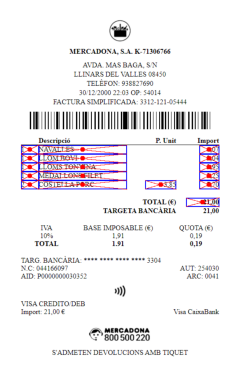

In [17]:
pilImg = Image.open('%s/%s' %(image_root, '000001.png'))

imgdrw = ImageDraw.Draw(pilImg)

for i in range(df_coco.shape[0]):
    imgdrw.regular_polygon((df_coco.x_centre[i], df_coco.y_centre[i], 5), 40, rotation=0, fill='red', outline=None, width=1)
    imgdrw.rectangle([df_coco.iloc[i].b_1, df_coco.iloc[i].b_4], outline = 'blue', width = 2)
    imgdrw.line((df_coco.iloc[i].b_1, df_coco.iloc[i].b_4), fill='red', width = 2)
    imgdrw.line((df_coco.iloc[i].b_2, df_coco.iloc[i].b_3), fill='red', width = 2)
    
plt.imshow(pilImg)
plt.axis('off');
plt.show()

#### Pintem tots els yolo:
- El primer de cada tipus de dataframe i de cada nivell de complexitat.

In [18]:
column_names = ['label', 'x_center_norm', 'y_center_norm', 'element_width_norm', 'element_height_norm']

def comprovar_yolo(df_root, image_root, file_name):
    df_yolo = pd.read_csv(df_root, sep=' ', names=column_names, dtype={'ticket_id': str})

    pilImg = Image.open('%s/%s' %(image_root, f'{file_name}.png'))
    imgdrw = ImageDraw.Draw(pilImg)
    w, h = pilImg.size

    df_yolo['x_center'] = df_yolo['x_center_norm'] *w
    df_yolo['y_center'] = df_yolo['y_center_norm'] *h
    df_yolo['element_width'] = df_yolo['element_width_norm'] *w
    df_yolo['element_height'] = df_yolo['element_height_norm'] *h

    df_yolo['b_1'] = df_yolo.apply(lambda row: (row['x_center'] -row['element_width'] /2, row['y_center'] -row['element_height'] /2), axis=1)
    df_yolo['b_2'] = df_yolo.apply(lambda row: (row['x_center'] +row['element_width'] /2, row['y_center'] -row['element_height'] /2), axis=1)
    df_yolo['b_3'] = df_yolo.apply(lambda row: (row['x_center'] -row['element_width'] /2, row['y_center'] +row['element_height'] /2), axis=1)
    df_yolo['b_4'] = df_yolo.apply(lambda row: (row['x_center'] +row['element_width'] /2, row['y_center'] +row['element_height'] /2), axis=1)

    imgdrw = ImageDraw.Draw(pilImg)
    
    for i in range(df_yolo.shape[0]):
        imgdrw.regular_polygon((df_yolo.x_center[i], df_yolo.y_center[i], 5), 40, rotation=0, fill='red', outline=None, width=1)
        imgdrw.rectangle([df_yolo.iloc[i].b_1, df_yolo.iloc[i].b_4], outline = 'blue', width = 2)
        imgdrw.line((df_yolo.iloc[i].b_1, df_yolo.iloc[i].b_4), fill='red', width = 2)
        imgdrw.line((df_yolo.iloc[i].b_2, df_yolo.iloc[i].b_3), fill='red', width = 2)

    plt.imshow(pilImg)
    plt.axis('off');
    plt.show()

=== Complexitat del dataset: 0 ===
=== Dataset: tickets ===


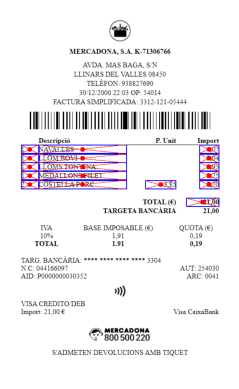

=== Dataset: cropped_area_products_in_ticket/cuted_section ===


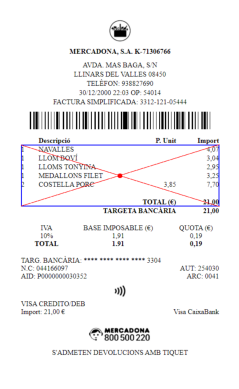

=== Dataset: cropped_area_products_in_ticket/products_on_cuted_section ===


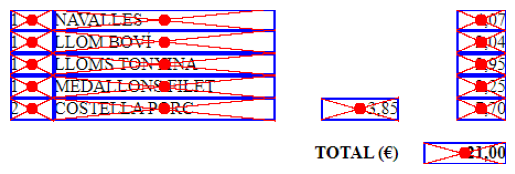

=== Complexitat del dataset: 1 ===
=== Dataset: tickets ===


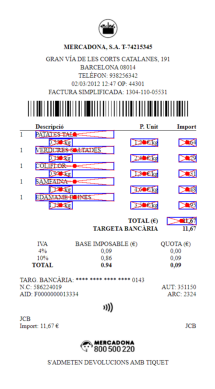

=== Dataset: cropped_area_products_in_ticket/cuted_section ===


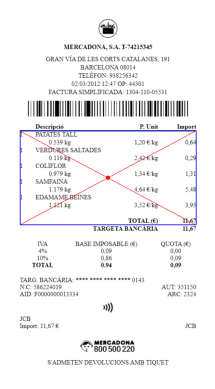

=== Dataset: cropped_area_products_in_ticket/products_on_cuted_section ===


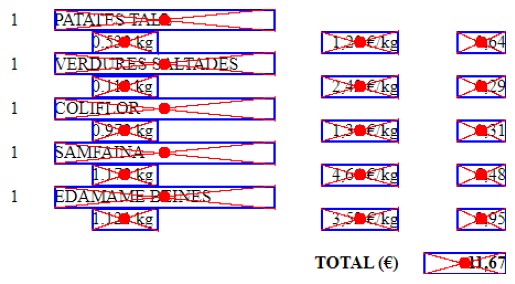

=== Complexitat del dataset: 2 ===
=== Dataset: tickets ===


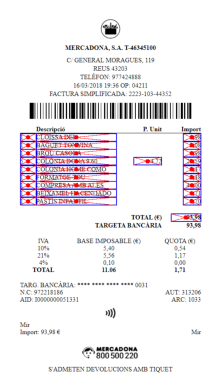

=== Dataset: cropped_area_products_in_ticket/cuted_section ===


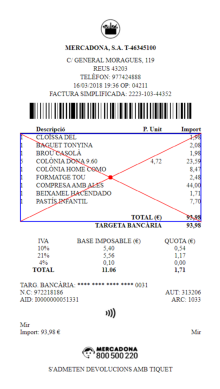

=== Dataset: cropped_area_products_in_ticket/products_on_cuted_section ===


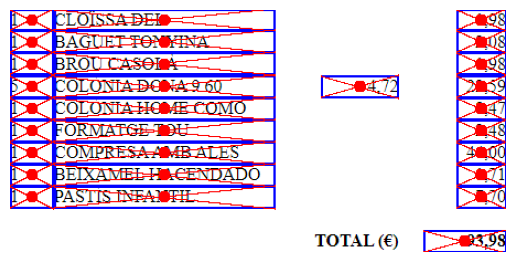

=== Complexitat del dataset: 3 ===
=== Dataset: tickets ===


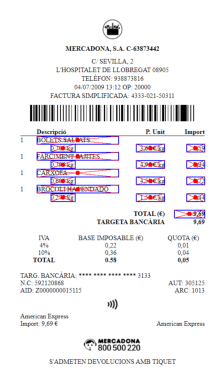

=== Dataset: cropped_area_products_in_ticket/cuted_section ===


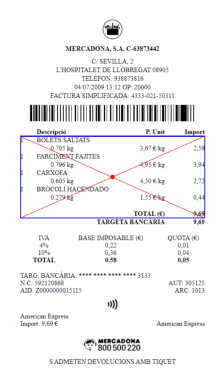

=== Dataset: cropped_area_products_in_ticket/products_on_cuted_section ===


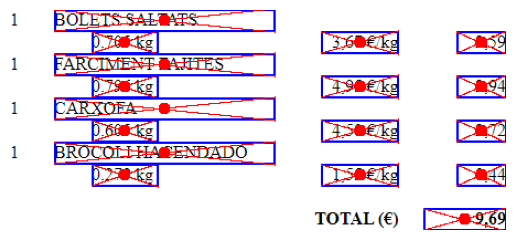

=== Complexitat del dataset: 4 ===
=== Dataset: tickets ===


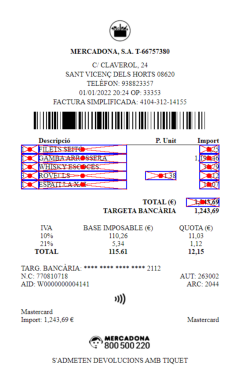

=== Dataset: cropped_area_products_in_ticket/cuted_section ===


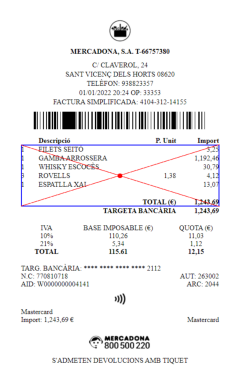

=== Dataset: cropped_area_products_in_ticket/products_on_cuted_section ===


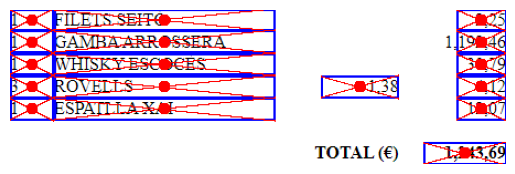

=== Complexitat del dataset: 5 ===
=== Dataset: tickets ===


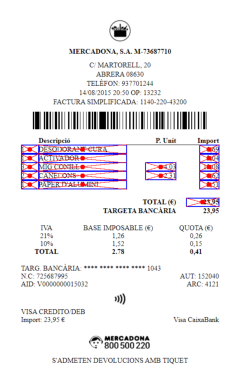

=== Dataset: cropped_area_products_in_ticket/cuted_section ===


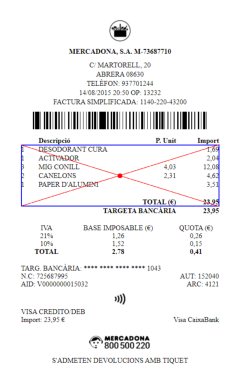

=== Dataset: cropped_area_products_in_ticket/products_on_cuted_section ===


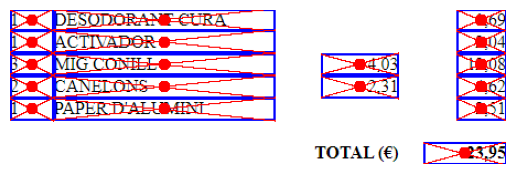

In [19]:
datasets = [
    'tickets',
    'cropped_area_products_in_ticket/cuted_section',
    'cropped_area_products_in_ticket/products_on_cuted_section',
]

for i in range(6):
    print(f"=== Complexitat del dataset: {i} ===")
    for dataset in datasets:
        print(f"=== Dataset: {dataset} ===")
        
        image_root = f'{image_root_general}/complexity_{i}/yolo/{dataset}/images/train/'
        file_name = '000001'
        df_root = f'{image_root_general}/complexity_{i}/yolo/{dataset}/labels/train/000001.txt'

        comprovar_yolo(df_root, image_root, file_name)

#### train/test
- Si fessim nosaltres un train/test amb el format coco, com que al dataset els registres de cada tiquet estàn separats per diferents registres. hem de fer el train/test per id. 
- Per soucionar això, hem fet el train/test, dels ids dels tiquests per separats i després hem agafat totes les seves dades:

#### Això no ho necessitarem perquè entrenarem el model amb dades en format yolo i no coco.
- Però havia sigut el primer approach que havíem fet

In [20]:
df = coco_products_in_ticket(5)

df.head()

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4
0,000001,quantitat_ud,1,"(25, 310)","(65, 310)","(25, 330)","(65, 330)"
1,000001,descripcio,DESODORANT CURA,"(65, 310)","(265, 310)","(65, 330)","(265, 330)"
2,000001,import,"1,69","(430, 310)","(475, 310)","(430, 330)","(475, 330)"
3,000001,quantitat_ud,1,"(25, 330)","(65, 330)","(25, 350)","(65, 350)"
4,000001,descripcio,ACTIVADOR,"(65, 330)","(265, 330)","(65, 350)","(265, 350)"


In [21]:
from sklearn.model_selection import train_test_split

In [22]:
df.ticket_id.unique()

array(['000001', '000002', '000003', '000004', '000005', '000006',
       '000007', '000008', '000009', '000010'], dtype=object)

In [23]:
df.groupby('ticket_id')

In [24]:
for ticket_id, info in df.groupby('ticket_id'):
    print(ticket_id)
    #print(info)
    break

000001


In [25]:
ticket_ids_train, ticket_ids_test = train_test_split(df.ticket_id.unique(), test_size=0.2, random_state=42)

In [26]:
ticket_ids_train

array(['000006', '000001', '000008', '000003', '000010', '000005',
       '000004', '000007'], dtype=object)

In [27]:
ticket_ids_test

array(['000009', '000002'], dtype=object)

In [28]:
X_train = df[df['ticket_id'].isin(ticket_ids_train)]
X_train.head()

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4
0,000001,quantitat_ud,1,"(25, 310)","(65, 310)","(25, 330)","(65, 330)"
1,000001,descripcio,DESODORANT CURA,"(65, 310)","(265, 310)","(65, 330)","(265, 330)"
2,000001,import,"1,69","(430, 310)","(475, 310)","(430, 330)","(475, 330)"
3,000001,quantitat_ud,1,"(25, 330)","(65, 330)","(25, 350)","(65, 350)"
4,000001,descripcio,ACTIVADOR,"(65, 330)","(265, 330)","(65, 350)","(265, 350)"


In [29]:
X_test = df[df['ticket_id'].isin(ticket_ids_test)]
X_test.head()

,ticket_id,etiqueta,value,b_1,b_2,b_3,b_4
18,000002,quantitat_ud,1,"(25, 310)","(65, 310)","(25, 330)","(65, 330)"
19,000002,descripcio,BLAT MORO DOLÇ,"(65, 310)","(265, 310)","(65, 330)","(265, 330)"
20,000002,import,"1,26","(430, 310)","(475, 310)","(430, 330)","(475, 330)"
21,000002,quantitat_ud,4,"(25, 330)","(65, 330)","(25, 350)","(65, 350)"
22,000002,descripcio,PASTÍS INFANTIL,"(65, 330)","(265, 330)","(65, 350)","(265, 350)"
